# PyTorch入门与实战第六课 

褚则伟 zeweichu@gmail.com

### 目录
- 图片风格迁移 
- 用GAN生成MNIST
- 用DCGAN生成更复杂的图片

## 图片风格迁移 Neural Style Transfer 

[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)
本文介绍了Neural Style Transfor模型


[Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf)


In [108]:
%matplotlib inline

from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
]) # 来自ImageNet的mean和variance

content = load_image("png/content.png", transform, max_size=400)
stype = load_image("png/style.png", transform, shape=[content.size(2), content.size(3)])

# content = load_image("png/content.png", transforms.Compose([
#     transforms.ToTensor(),
# ]), max_size=400)
# style = load_image("png/style.png", transforms.Compose([
#     transforms.ToTensor(),
# ]), shape=[content.size(2), content.size(3)])

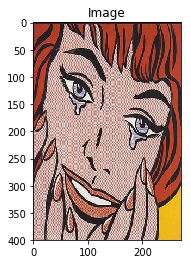

In [17]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Image')
# content.shape

In [34]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

In [35]:
target_features = vgg(target)

In [42]:
total_step = 2000
style_weight = 100.
for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    style_loss = 0
    content_loss = 0
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        # 计算gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2)/(c*h*w)
        
    loss = content_loss + style_weight * style_loss
    
    # 更新target
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))  

Step [0/2000], Content Loss: 0.0000, Style Loss: 531.1730
Step [10/2000], Content Loss: 6.0654, Style Loss: 360.6187
Step [20/2000], Content Loss: 11.3430, Style Loss: 253.8006
Step [30/2000], Content Loss: 14.5195, Style Loss: 190.0798
Step [40/2000], Content Loss: 16.5578, Style Loss: 152.3939
Step [50/2000], Content Loss: 17.9683, Style Loss: 129.4922
Step [60/2000], Content Loss: 19.0225, Style Loss: 114.5218
Step [70/2000], Content Loss: 19.8584, Style Loss: 103.7824
Step [80/2000], Content Loss: 20.5509, Style Loss: 95.5047
Step [90/2000], Content Loss: 21.1601, Style Loss: 88.7919
Step [100/2000], Content Loss: 21.6844, Style Loss: 83.1393
Step [110/2000], Content Loss: 22.1447, Style Loss: 78.2809
Step [120/2000], Content Loss: 22.5605, Style Loss: 74.0401
Step [130/2000], Content Loss: 22.9415, Style Loss: 70.2842
Step [140/2000], Content Loss: 23.2941, Style Loss: 66.9353
Step [150/2000], Content Loss: 23.6130, Style Loss: 63.9158
Step [160/2000], Content Loss: 23.9114, Style

Step [1370/2000], Content Loss: 32.0038, Style Loss: 9.8461
Step [1380/2000], Content Loss: 32.0191, Style Loss: 9.7687
Step [1390/2000], Content Loss: 32.0434, Style Loss: 9.6970
Step [1400/2000], Content Loss: 32.0572, Style Loss: 9.6203
Step [1410/2000], Content Loss: 32.0787, Style Loss: 9.5496
Step [1420/2000], Content Loss: 32.0955, Style Loss: 9.4771
Step [1430/2000], Content Loss: 32.1123, Style Loss: 9.4056
Step [1440/2000], Content Loss: 32.1289, Style Loss: 9.3349
Step [1450/2000], Content Loss: 32.1441, Style Loss: 9.2636
Step [1460/2000], Content Loss: 32.1628, Style Loss: 9.1949
Step [1470/2000], Content Loss: 32.1851, Style Loss: 9.1302
Step [1480/2000], Content Loss: 32.1958, Style Loss: 9.0589
Step [1490/2000], Content Loss: 32.2141, Style Loss: 8.9938
Step [1500/2000], Content Loss: 32.2303, Style Loss: 8.9282
Step [1510/2000], Content Loss: 32.2414, Style Loss: 8.8597
Step [1520/2000], Content Loss: 32.2560, Style Loss: 8.7944
Step [1530/2000], Content Loss: 32.2785,

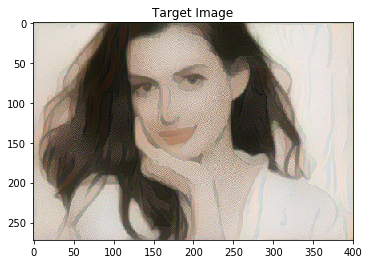

In [48]:
denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
plt.figure()
imshow(img, title='Target Image')

## Generative Adversarial Networks

In [52]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                        std=(0.5, 0.5, 0.5))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

In [53]:
image_size = 784

hidden_size = 256
# discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64
# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

开始训练

In [56]:

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

total_step = len(dataloader)
num_epochs = 200
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.size(0)
        images = images.reshape(batch_size, image_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs
        
        # 开始优化discriminator
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 开始优化generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels)
        
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
        

Epoch [0/200], Step [0/1875], d_loss: 1.2569, g_loss: 0.6755, D(x): 0.58, D(G(z)): 0.51
Epoch [0/200], Step [200/1875], d_loss: 0.0559, g_loss: 4.2038, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/1875], d_loss: 0.1786, g_loss: 4.7978, D(x): 0.93, D(G(z)): 0.05
Epoch [0/200], Step [600/1875], d_loss: 0.0324, g_loss: 5.0986, D(x): 0.99, D(G(z)): 0.02
Epoch [0/200], Step [800/1875], d_loss: 0.1017, g_loss: 5.0152, D(x): 0.96, D(G(z)): 0.04
Epoch [0/200], Step [1000/1875], d_loss: 0.4446, g_loss: 2.9132, D(x): 0.79, D(G(z)): 0.04
Epoch [0/200], Step [1200/1875], d_loss: 0.4018, g_loss: 3.3933, D(x): 0.93, D(G(z)): 0.24
Epoch [0/200], Step [1400/1875], d_loss: 0.1677, g_loss: 4.4938, D(x): 0.93, D(G(z)): 0.03
Epoch [0/200], Step [1600/1875], d_loss: 0.4466, g_loss: 2.0543, D(x): 0.86, D(G(z)): 0.20
Epoch [0/200], Step [1800/1875], d_loss: 0.3877, g_loss: 2.6006, D(x): 0.85, D(G(z)): 0.10
Epoch [1/200], Step [0/1875], d_loss: 1.5200, g_loss: 2.9892, D(x): 0.73, D(G(z)): 0.56
Epoch [1/

Epoch [9/200], Step [200/1875], d_loss: 0.4947, g_loss: 3.0497, D(x): 0.93, D(G(z)): 0.24
Epoch [9/200], Step [400/1875], d_loss: 0.1445, g_loss: 3.5805, D(x): 0.97, D(G(z)): 0.10
Epoch [9/200], Step [600/1875], d_loss: 0.5058, g_loss: 5.5955, D(x): 0.81, D(G(z)): 0.05
Epoch [9/200], Step [800/1875], d_loss: 0.1665, g_loss: 2.9392, D(x): 0.93, D(G(z)): 0.06
Epoch [9/200], Step [1000/1875], d_loss: 0.3438, g_loss: 3.2496, D(x): 0.89, D(G(z)): 0.08
Epoch [9/200], Step [1200/1875], d_loss: 0.6963, g_loss: 3.1455, D(x): 0.73, D(G(z)): 0.07
Epoch [9/200], Step [1400/1875], d_loss: 0.5343, g_loss: 3.2310, D(x): 0.84, D(G(z)): 0.15
Epoch [9/200], Step [1600/1875], d_loss: 0.8017, g_loss: 2.5374, D(x): 0.92, D(G(z)): 0.38
Epoch [9/200], Step [1800/1875], d_loss: 0.7319, g_loss: 2.9365, D(x): 0.78, D(G(z)): 0.16
Epoch [10/200], Step [0/1875], d_loss: 0.4828, g_loss: 3.4405, D(x): 0.81, D(G(z)): 0.11
Epoch [10/200], Step [200/1875], d_loss: 0.5769, g_loss: 4.6555, D(x): 0.77, D(G(z)): 0.07
Epoch

Epoch [18/200], Step [200/1875], d_loss: 0.6800, g_loss: 2.2731, D(x): 0.76, D(G(z)): 0.19
Epoch [18/200], Step [400/1875], d_loss: 0.8124, g_loss: 2.6561, D(x): 0.73, D(G(z)): 0.25
Epoch [18/200], Step [600/1875], d_loss: 0.7504, g_loss: 2.1835, D(x): 0.68, D(G(z)): 0.17
Epoch [18/200], Step [800/1875], d_loss: 0.7642, g_loss: 2.6195, D(x): 0.69, D(G(z)): 0.16
Epoch [18/200], Step [1000/1875], d_loss: 0.4710, g_loss: 2.6943, D(x): 0.85, D(G(z)): 0.19
Epoch [18/200], Step [1200/1875], d_loss: 0.9731, g_loss: 1.9779, D(x): 0.63, D(G(z)): 0.18
Epoch [18/200], Step [1400/1875], d_loss: 0.9539, g_loss: 1.7567, D(x): 0.73, D(G(z)): 0.28
Epoch [18/200], Step [1600/1875], d_loss: 0.7254, g_loss: 1.9887, D(x): 0.72, D(G(z)): 0.19
Epoch [18/200], Step [1800/1875], d_loss: 0.9706, g_loss: 2.5323, D(x): 0.67, D(G(z)): 0.23
Epoch [19/200], Step [0/1875], d_loss: 0.7767, g_loss: 3.0137, D(x): 0.79, D(G(z)): 0.27
Epoch [19/200], Step [200/1875], d_loss: 1.0162, g_loss: 2.2788, D(x): 0.57, D(G(z)): 0

Epoch [27/200], Step [200/1875], d_loss: 0.8053, g_loss: 1.8962, D(x): 0.77, D(G(z)): 0.29
Epoch [27/200], Step [400/1875], d_loss: 0.9472, g_loss: 1.8516, D(x): 0.58, D(G(z)): 0.18
Epoch [27/200], Step [600/1875], d_loss: 0.6617, g_loss: 1.2219, D(x): 0.86, D(G(z)): 0.33
Epoch [27/200], Step [800/1875], d_loss: 0.9218, g_loss: 1.8212, D(x): 0.66, D(G(z)): 0.23
Epoch [27/200], Step [1000/1875], d_loss: 0.5367, g_loss: 1.4264, D(x): 0.79, D(G(z)): 0.19
Epoch [27/200], Step [1200/1875], d_loss: 0.9549, g_loss: 1.7967, D(x): 0.77, D(G(z)): 0.40
Epoch [27/200], Step [1400/1875], d_loss: 1.1361, g_loss: 1.2867, D(x): 0.85, D(G(z)): 0.49
Epoch [27/200], Step [1600/1875], d_loss: 0.8159, g_loss: 1.4106, D(x): 0.73, D(G(z)): 0.30
Epoch [27/200], Step [1800/1875], d_loss: 0.9717, g_loss: 2.3105, D(x): 0.57, D(G(z)): 0.21
Epoch [28/200], Step [0/1875], d_loss: 0.8664, g_loss: 1.4382, D(x): 0.67, D(G(z)): 0.25
Epoch [28/200], Step [200/1875], d_loss: 0.9418, g_loss: 1.9146, D(x): 0.66, D(G(z)): 0

Epoch [36/200], Step [200/1875], d_loss: 0.9371, g_loss: 1.5939, D(x): 0.62, D(G(z)): 0.23
Epoch [36/200], Step [400/1875], d_loss: 1.0236, g_loss: 1.5185, D(x): 0.63, D(G(z)): 0.27
Epoch [36/200], Step [600/1875], d_loss: 0.8211, g_loss: 1.3640, D(x): 0.78, D(G(z)): 0.33
Epoch [36/200], Step [800/1875], d_loss: 0.9821, g_loss: 2.1804, D(x): 0.64, D(G(z)): 0.26
Epoch [36/200], Step [1000/1875], d_loss: 0.8219, g_loss: 1.7719, D(x): 0.64, D(G(z)): 0.21
Epoch [36/200], Step [1200/1875], d_loss: 0.7591, g_loss: 1.4298, D(x): 0.76, D(G(z)): 0.24
Epoch [36/200], Step [1400/1875], d_loss: 0.6965, g_loss: 1.8425, D(x): 0.74, D(G(z)): 0.23
Epoch [36/200], Step [1600/1875], d_loss: 0.7921, g_loss: 1.6806, D(x): 0.68, D(G(z)): 0.22
Epoch [36/200], Step [1800/1875], d_loss: 0.8588, g_loss: 1.5613, D(x): 0.72, D(G(z)): 0.29
Epoch [37/200], Step [0/1875], d_loss: 0.6945, g_loss: 1.5609, D(x): 0.80, D(G(z)): 0.31
Epoch [37/200], Step [200/1875], d_loss: 0.7174, g_loss: 1.4134, D(x): 0.85, D(G(z)): 0

Epoch [45/200], Step [200/1875], d_loss: 0.9172, g_loss: 1.4683, D(x): 0.66, D(G(z)): 0.30
Epoch [45/200], Step [400/1875], d_loss: 1.1497, g_loss: 1.5283, D(x): 0.64, D(G(z)): 0.36
Epoch [45/200], Step [600/1875], d_loss: 0.8806, g_loss: 1.6429, D(x): 0.70, D(G(z)): 0.28
Epoch [45/200], Step [800/1875], d_loss: 0.8461, g_loss: 2.0925, D(x): 0.67, D(G(z)): 0.24
Epoch [45/200], Step [1000/1875], d_loss: 0.9001, g_loss: 1.7370, D(x): 0.64, D(G(z)): 0.26
Epoch [45/200], Step [1200/1875], d_loss: 0.8153, g_loss: 1.8944, D(x): 0.74, D(G(z)): 0.29
Epoch [45/200], Step [1400/1875], d_loss: 1.2539, g_loss: 1.8340, D(x): 0.63, D(G(z)): 0.39
Epoch [45/200], Step [1600/1875], d_loss: 1.0185, g_loss: 1.4904, D(x): 0.65, D(G(z)): 0.34
Epoch [45/200], Step [1800/1875], d_loss: 0.8973, g_loss: 1.8646, D(x): 0.62, D(G(z)): 0.17
Epoch [46/200], Step [0/1875], d_loss: 0.8639, g_loss: 2.1760, D(x): 0.63, D(G(z)): 0.18
Epoch [46/200], Step [200/1875], d_loss: 1.1033, g_loss: 1.6140, D(x): 0.61, D(G(z)): 0

Epoch [54/200], Step [200/1875], d_loss: 0.8881, g_loss: 1.4966, D(x): 0.74, D(G(z)): 0.36
Epoch [54/200], Step [400/1875], d_loss: 0.7393, g_loss: 1.4056, D(x): 0.72, D(G(z)): 0.26
Epoch [54/200], Step [600/1875], d_loss: 0.9261, g_loss: 1.9644, D(x): 0.69, D(G(z)): 0.30
Epoch [54/200], Step [800/1875], d_loss: 0.8253, g_loss: 1.7376, D(x): 0.66, D(G(z)): 0.21
Epoch [54/200], Step [1000/1875], d_loss: 1.0303, g_loss: 1.0349, D(x): 0.79, D(G(z)): 0.42
Epoch [54/200], Step [1200/1875], d_loss: 1.0796, g_loss: 0.9907, D(x): 0.70, D(G(z)): 0.40
Epoch [54/200], Step [1400/1875], d_loss: 0.8628, g_loss: 1.3799, D(x): 0.79, D(G(z)): 0.39
Epoch [54/200], Step [1600/1875], d_loss: 0.9324, g_loss: 1.5343, D(x): 0.60, D(G(z)): 0.24
Epoch [54/200], Step [1800/1875], d_loss: 0.8601, g_loss: 1.6669, D(x): 0.67, D(G(z)): 0.21
Epoch [55/200], Step [0/1875], d_loss: 0.9787, g_loss: 1.8346, D(x): 0.62, D(G(z)): 0.26
Epoch [55/200], Step [200/1875], d_loss: 0.9772, g_loss: 1.8804, D(x): 0.71, D(G(z)): 0

Epoch [63/200], Step [200/1875], d_loss: 1.0672, g_loss: 1.3059, D(x): 0.61, D(G(z)): 0.33
Epoch [63/200], Step [400/1875], d_loss: 0.8085, g_loss: 1.5071, D(x): 0.69, D(G(z)): 0.26
Epoch [63/200], Step [600/1875], d_loss: 1.1137, g_loss: 1.3016, D(x): 0.75, D(G(z)): 0.46
Epoch [63/200], Step [800/1875], d_loss: 0.9666, g_loss: 1.2797, D(x): 0.66, D(G(z)): 0.32
Epoch [63/200], Step [1000/1875], d_loss: 1.1635, g_loss: 1.5748, D(x): 0.74, D(G(z)): 0.46
Epoch [63/200], Step [1200/1875], d_loss: 1.1777, g_loss: 1.1466, D(x): 0.58, D(G(z)): 0.27
Epoch [63/200], Step [1400/1875], d_loss: 0.9481, g_loss: 0.8562, D(x): 0.70, D(G(z)): 0.35
Epoch [63/200], Step [1600/1875], d_loss: 0.9025, g_loss: 1.0285, D(x): 0.67, D(G(z)): 0.28
Epoch [63/200], Step [1800/1875], d_loss: 1.0764, g_loss: 1.1190, D(x): 0.70, D(G(z)): 0.39
Epoch [64/200], Step [0/1875], d_loss: 0.8341, g_loss: 1.6108, D(x): 0.66, D(G(z)): 0.24
Epoch [64/200], Step [200/1875], d_loss: 0.8228, g_loss: 1.5171, D(x): 0.73, D(G(z)): 0

Epoch [72/200], Step [200/1875], d_loss: 0.9577, g_loss: 1.2292, D(x): 0.84, D(G(z)): 0.44
Epoch [72/200], Step [400/1875], d_loss: 0.9612, g_loss: 1.4265, D(x): 0.73, D(G(z)): 0.39
Epoch [72/200], Step [600/1875], d_loss: 0.9172, g_loss: 1.0200, D(x): 0.73, D(G(z)): 0.38
Epoch [72/200], Step [800/1875], d_loss: 1.3149, g_loss: 1.7419, D(x): 0.57, D(G(z)): 0.32
Epoch [72/200], Step [1000/1875], d_loss: 1.0422, g_loss: 1.1678, D(x): 0.66, D(G(z)): 0.38
Epoch [72/200], Step [1200/1875], d_loss: 0.9326, g_loss: 1.3312, D(x): 0.72, D(G(z)): 0.33
Epoch [72/200], Step [1400/1875], d_loss: 0.9343, g_loss: 1.9300, D(x): 0.62, D(G(z)): 0.26
Epoch [72/200], Step [1600/1875], d_loss: 1.0011, g_loss: 1.3257, D(x): 0.65, D(G(z)): 0.31
Epoch [72/200], Step [1800/1875], d_loss: 1.2874, g_loss: 1.4102, D(x): 0.66, D(G(z)): 0.46
Epoch [73/200], Step [0/1875], d_loss: 0.9844, g_loss: 1.4167, D(x): 0.81, D(G(z)): 0.47
Epoch [73/200], Step [200/1875], d_loss: 0.9753, g_loss: 1.8121, D(x): 0.64, D(G(z)): 0

Epoch [81/200], Step [200/1875], d_loss: 0.9573, g_loss: 1.3561, D(x): 0.70, D(G(z)): 0.35
Epoch [81/200], Step [400/1875], d_loss: 1.0440, g_loss: 1.5524, D(x): 0.63, D(G(z)): 0.33
Epoch [81/200], Step [600/1875], d_loss: 0.8451, g_loss: 1.4375, D(x): 0.71, D(G(z)): 0.29
Epoch [81/200], Step [800/1875], d_loss: 0.9466, g_loss: 1.1077, D(x): 0.62, D(G(z)): 0.23
Epoch [81/200], Step [1000/1875], d_loss: 0.9877, g_loss: 1.6569, D(x): 0.63, D(G(z)): 0.31
Epoch [81/200], Step [1200/1875], d_loss: 0.9070, g_loss: 1.4163, D(x): 0.77, D(G(z)): 0.35
Epoch [81/200], Step [1400/1875], d_loss: 1.2290, g_loss: 1.3130, D(x): 0.61, D(G(z)): 0.36
Epoch [81/200], Step [1600/1875], d_loss: 0.9066, g_loss: 1.2354, D(x): 0.76, D(G(z)): 0.37
Epoch [81/200], Step [1800/1875], d_loss: 1.0070, g_loss: 1.1705, D(x): 0.65, D(G(z)): 0.34
Epoch [82/200], Step [0/1875], d_loss: 0.9985, g_loss: 1.2853, D(x): 0.58, D(G(z)): 0.16
Epoch [82/200], Step [200/1875], d_loss: 1.1751, g_loss: 2.0278, D(x): 0.75, D(G(z)): 0

Epoch [90/200], Step [200/1875], d_loss: 0.7712, g_loss: 1.8708, D(x): 0.67, D(G(z)): 0.22
Epoch [90/200], Step [400/1875], d_loss: 1.0285, g_loss: 1.1315, D(x): 0.73, D(G(z)): 0.38
Epoch [90/200], Step [600/1875], d_loss: 1.0383, g_loss: 1.4412, D(x): 0.56, D(G(z)): 0.26
Epoch [90/200], Step [800/1875], d_loss: 1.2032, g_loss: 1.2842, D(x): 0.64, D(G(z)): 0.39
Epoch [90/200], Step [1000/1875], d_loss: 1.2429, g_loss: 1.4935, D(x): 0.48, D(G(z)): 0.26
Epoch [90/200], Step [1200/1875], d_loss: 0.9445, g_loss: 1.5705, D(x): 0.74, D(G(z)): 0.38
Epoch [90/200], Step [1400/1875], d_loss: 1.0112, g_loss: 1.2587, D(x): 0.61, D(G(z)): 0.30
Epoch [90/200], Step [1600/1875], d_loss: 0.9815, g_loss: 1.4418, D(x): 0.67, D(G(z)): 0.33
Epoch [90/200], Step [1800/1875], d_loss: 0.9308, g_loss: 1.2380, D(x): 0.77, D(G(z)): 0.39
Epoch [91/200], Step [0/1875], d_loss: 0.7898, g_loss: 1.9128, D(x): 0.72, D(G(z)): 0.29
Epoch [91/200], Step [200/1875], d_loss: 0.9437, g_loss: 1.1238, D(x): 0.69, D(G(z)): 0

Epoch [99/200], Step [200/1875], d_loss: 1.0595, g_loss: 1.4754, D(x): 0.72, D(G(z)): 0.39
Epoch [99/200], Step [400/1875], d_loss: 1.0425, g_loss: 1.0321, D(x): 0.69, D(G(z)): 0.40
Epoch [99/200], Step [600/1875], d_loss: 0.9218, g_loss: 1.4052, D(x): 0.65, D(G(z)): 0.31
Epoch [99/200], Step [800/1875], d_loss: 1.1420, g_loss: 1.1176, D(x): 0.69, D(G(z)): 0.44
Epoch [99/200], Step [1000/1875], d_loss: 1.0196, g_loss: 1.1938, D(x): 0.71, D(G(z)): 0.39
Epoch [99/200], Step [1200/1875], d_loss: 1.0105, g_loss: 1.4404, D(x): 0.71, D(G(z)): 0.37
Epoch [99/200], Step [1400/1875], d_loss: 0.7694, g_loss: 1.9539, D(x): 0.65, D(G(z)): 0.19
Epoch [99/200], Step [1600/1875], d_loss: 0.8992, g_loss: 1.2274, D(x): 0.68, D(G(z)): 0.32
Epoch [99/200], Step [1800/1875], d_loss: 1.0253, g_loss: 1.4236, D(x): 0.66, D(G(z)): 0.32
Epoch [100/200], Step [0/1875], d_loss: 1.0045, g_loss: 1.3612, D(x): 0.75, D(G(z)): 0.43
Epoch [100/200], Step [200/1875], d_loss: 1.0858, g_loss: 1.3179, D(x): 0.65, D(G(z)):

Epoch [108/200], Step [0/1875], d_loss: 1.2703, g_loss: 1.1474, D(x): 0.64, D(G(z)): 0.41
Epoch [108/200], Step [200/1875], d_loss: 0.7179, g_loss: 1.5282, D(x): 0.78, D(G(z)): 0.30
Epoch [108/200], Step [400/1875], d_loss: 1.0354, g_loss: 1.3934, D(x): 0.53, D(G(z)): 0.18
Epoch [108/200], Step [600/1875], d_loss: 0.9802, g_loss: 1.0129, D(x): 0.69, D(G(z)): 0.35
Epoch [108/200], Step [800/1875], d_loss: 0.9632, g_loss: 1.5734, D(x): 0.67, D(G(z)): 0.32
Epoch [108/200], Step [1000/1875], d_loss: 1.1324, g_loss: 1.5598, D(x): 0.62, D(G(z)): 0.37
Epoch [108/200], Step [1200/1875], d_loss: 0.9626, g_loss: 1.5857, D(x): 0.76, D(G(z)): 0.40
Epoch [108/200], Step [1400/1875], d_loss: 1.1046, g_loss: 1.6022, D(x): 0.69, D(G(z)): 0.41
Epoch [108/200], Step [1600/1875], d_loss: 1.0280, g_loss: 1.3688, D(x): 0.64, D(G(z)): 0.32
Epoch [108/200], Step [1800/1875], d_loss: 1.0522, g_loss: 1.6160, D(x): 0.67, D(G(z)): 0.37
Epoch [109/200], Step [0/1875], d_loss: 0.9837, g_loss: 1.2750, D(x): 0.64, D

Epoch [116/200], Step [1800/1875], d_loss: 1.0110, g_loss: 1.4432, D(x): 0.65, D(G(z)): 0.35
Epoch [117/200], Step [0/1875], d_loss: 0.9797, g_loss: 1.1187, D(x): 0.64, D(G(z)): 0.32
Epoch [117/200], Step [200/1875], d_loss: 1.1501, g_loss: 1.3493, D(x): 0.63, D(G(z)): 0.33
Epoch [117/200], Step [400/1875], d_loss: 0.9746, g_loss: 1.5517, D(x): 0.61, D(G(z)): 0.29
Epoch [117/200], Step [600/1875], d_loss: 0.8904, g_loss: 1.3899, D(x): 0.66, D(G(z)): 0.26
Epoch [117/200], Step [800/1875], d_loss: 0.9449, g_loss: 2.1154, D(x): 0.65, D(G(z)): 0.28
Epoch [117/200], Step [1000/1875], d_loss: 0.7482, g_loss: 1.5939, D(x): 0.67, D(G(z)): 0.22
Epoch [117/200], Step [1200/1875], d_loss: 0.9199, g_loss: 1.6167, D(x): 0.71, D(G(z)): 0.34
Epoch [117/200], Step [1400/1875], d_loss: 0.9082, g_loss: 1.3808, D(x): 0.70, D(G(z)): 0.33
Epoch [117/200], Step [1600/1875], d_loss: 1.0032, g_loss: 1.2413, D(x): 0.67, D(G(z)): 0.36
Epoch [117/200], Step [1800/1875], d_loss: 0.8869, g_loss: 1.3589, D(x): 0.72

Epoch [125/200], Step [1600/1875], d_loss: 1.2272, g_loss: 1.9570, D(x): 0.52, D(G(z)): 0.25
Epoch [125/200], Step [1800/1875], d_loss: 1.2752, g_loss: 1.7465, D(x): 0.60, D(G(z)): 0.37
Epoch [126/200], Step [0/1875], d_loss: 1.1152, g_loss: 1.2765, D(x): 0.63, D(G(z)): 0.30
Epoch [126/200], Step [200/1875], d_loss: 0.8351, g_loss: 1.5520, D(x): 0.69, D(G(z)): 0.26
Epoch [126/200], Step [400/1875], d_loss: 0.9641, g_loss: 1.3715, D(x): 0.69, D(G(z)): 0.31
Epoch [126/200], Step [600/1875], d_loss: 0.9639, g_loss: 0.9140, D(x): 0.65, D(G(z)): 0.32
Epoch [126/200], Step [800/1875], d_loss: 1.3733, g_loss: 1.1390, D(x): 0.66, D(G(z)): 0.48
Epoch [126/200], Step [1000/1875], d_loss: 1.0701, g_loss: 1.4106, D(x): 0.61, D(G(z)): 0.32
Epoch [126/200], Step [1200/1875], d_loss: 1.1331, g_loss: 1.1971, D(x): 0.75, D(G(z)): 0.47
Epoch [126/200], Step [1400/1875], d_loss: 0.8382, g_loss: 1.5771, D(x): 0.66, D(G(z)): 0.26
Epoch [126/200], Step [1600/1875], d_loss: 0.9747, g_loss: 1.3442, D(x): 0.70

Epoch [134/200], Step [1400/1875], d_loss: 0.8448, g_loss: 1.3124, D(x): 0.72, D(G(z)): 0.31
Epoch [134/200], Step [1600/1875], d_loss: 1.1056, g_loss: 1.0849, D(x): 0.56, D(G(z)): 0.23
Epoch [134/200], Step [1800/1875], d_loss: 1.1300, g_loss: 1.4655, D(x): 0.54, D(G(z)): 0.30
Epoch [135/200], Step [0/1875], d_loss: 0.9943, g_loss: 1.5591, D(x): 0.71, D(G(z)): 0.36
Epoch [135/200], Step [200/1875], d_loss: 0.9815, g_loss: 1.5794, D(x): 0.68, D(G(z)): 0.31
Epoch [135/200], Step [400/1875], d_loss: 1.0170, g_loss: 0.9761, D(x): 0.68, D(G(z)): 0.35
Epoch [135/200], Step [600/1875], d_loss: 1.0302, g_loss: 1.4109, D(x): 0.64, D(G(z)): 0.31
Epoch [135/200], Step [800/1875], d_loss: 0.9374, g_loss: 2.1290, D(x): 0.57, D(G(z)): 0.16
Epoch [135/200], Step [1000/1875], d_loss: 0.8537, g_loss: 1.3824, D(x): 0.75, D(G(z)): 0.35
Epoch [135/200], Step [1200/1875], d_loss: 0.7731, g_loss: 1.0923, D(x): 0.73, D(G(z)): 0.30
Epoch [135/200], Step [1400/1875], d_loss: 1.0851, g_loss: 1.3332, D(x): 0.65

Epoch [143/200], Step [1200/1875], d_loss: 1.0397, g_loss: 1.0590, D(x): 0.64, D(G(z)): 0.33
Epoch [143/200], Step [1400/1875], d_loss: 0.9658, g_loss: 1.3453, D(x): 0.63, D(G(z)): 0.29
Epoch [143/200], Step [1600/1875], d_loss: 0.8047, g_loss: 1.3830, D(x): 0.72, D(G(z)): 0.32
Epoch [143/200], Step [1800/1875], d_loss: 1.0052, g_loss: 1.2554, D(x): 0.71, D(G(z)): 0.38
Epoch [144/200], Step [0/1875], d_loss: 0.7734, g_loss: 1.4231, D(x): 0.79, D(G(z)): 0.30
Epoch [144/200], Step [200/1875], d_loss: 0.8567, g_loss: 1.7460, D(x): 0.68, D(G(z)): 0.26
Epoch [144/200], Step [400/1875], d_loss: 0.8436, g_loss: 1.4875, D(x): 0.69, D(G(z)): 0.26
Epoch [144/200], Step [600/1875], d_loss: 0.9236, g_loss: 1.1447, D(x): 0.74, D(G(z)): 0.34
Epoch [144/200], Step [800/1875], d_loss: 1.0485, g_loss: 1.5442, D(x): 0.68, D(G(z)): 0.33
Epoch [144/200], Step [1000/1875], d_loss: 1.0730, g_loss: 1.4903, D(x): 0.72, D(G(z)): 0.37
Epoch [144/200], Step [1200/1875], d_loss: 1.1917, g_loss: 1.4977, D(x): 0.60

Epoch [152/200], Step [1000/1875], d_loss: 0.9931, g_loss: 0.9229, D(x): 0.57, D(G(z)): 0.24
Epoch [152/200], Step [1200/1875], d_loss: 0.9094, g_loss: 1.6908, D(x): 0.72, D(G(z)): 0.28
Epoch [152/200], Step [1400/1875], d_loss: 0.9227, g_loss: 1.6412, D(x): 0.72, D(G(z)): 0.32
Epoch [152/200], Step [1600/1875], d_loss: 1.2797, g_loss: 1.0787, D(x): 0.64, D(G(z)): 0.45
Epoch [152/200], Step [1800/1875], d_loss: 0.8744, g_loss: 1.2695, D(x): 0.72, D(G(z)): 0.33
Epoch [153/200], Step [0/1875], d_loss: 0.9579, g_loss: 1.6863, D(x): 0.68, D(G(z)): 0.31
Epoch [153/200], Step [200/1875], d_loss: 0.8000, g_loss: 1.6720, D(x): 0.78, D(G(z)): 0.33
Epoch [153/200], Step [400/1875], d_loss: 0.9033, g_loss: 1.3891, D(x): 0.69, D(G(z)): 0.28
Epoch [153/200], Step [600/1875], d_loss: 0.9845, g_loss: 1.5490, D(x): 0.64, D(G(z)): 0.29
Epoch [153/200], Step [800/1875], d_loss: 0.8599, g_loss: 1.3118, D(x): 0.76, D(G(z)): 0.35
Epoch [153/200], Step [1000/1875], d_loss: 1.0166, g_loss: 1.5448, D(x): 0.65

Epoch [161/200], Step [800/1875], d_loss: 1.1227, g_loss: 1.3172, D(x): 0.65, D(G(z)): 0.41
Epoch [161/200], Step [1000/1875], d_loss: 1.1837, g_loss: 1.1958, D(x): 0.56, D(G(z)): 0.28
Epoch [161/200], Step [1200/1875], d_loss: 1.1111, g_loss: 1.3070, D(x): 0.62, D(G(z)): 0.36
Epoch [161/200], Step [1400/1875], d_loss: 0.9705, g_loss: 1.3556, D(x): 0.70, D(G(z)): 0.35
Epoch [161/200], Step [1600/1875], d_loss: 0.7153, g_loss: 1.4424, D(x): 0.76, D(G(z)): 0.30
Epoch [161/200], Step [1800/1875], d_loss: 0.8991, g_loss: 1.3056, D(x): 0.83, D(G(z)): 0.41
Epoch [162/200], Step [0/1875], d_loss: 0.9102, g_loss: 1.5805, D(x): 0.69, D(G(z)): 0.33
Epoch [162/200], Step [200/1875], d_loss: 0.8583, g_loss: 2.0342, D(x): 0.65, D(G(z)): 0.24
Epoch [162/200], Step [400/1875], d_loss: 0.7230, g_loss: 1.6750, D(x): 0.74, D(G(z)): 0.27
Epoch [162/200], Step [600/1875], d_loss: 0.7382, g_loss: 1.3418, D(x): 0.71, D(G(z)): 0.24
Epoch [162/200], Step [800/1875], d_loss: 1.0604, g_loss: 1.4952, D(x): 0.64,

Epoch [170/200], Step [600/1875], d_loss: 0.9255, g_loss: 1.3560, D(x): 0.64, D(G(z)): 0.27
Epoch [170/200], Step [800/1875], d_loss: 1.0199, g_loss: 1.8127, D(x): 0.67, D(G(z)): 0.34
Epoch [170/200], Step [1000/1875], d_loss: 0.8829, g_loss: 2.1110, D(x): 0.71, D(G(z)): 0.33
Epoch [170/200], Step [1200/1875], d_loss: 1.0791, g_loss: 1.3807, D(x): 0.72, D(G(z)): 0.43
Epoch [170/200], Step [1400/1875], d_loss: 1.0644, g_loss: 1.6476, D(x): 0.65, D(G(z)): 0.32
Epoch [170/200], Step [1600/1875], d_loss: 1.0199, g_loss: 1.9927, D(x): 0.59, D(G(z)): 0.21
Epoch [170/200], Step [1800/1875], d_loss: 0.8158, g_loss: 1.2508, D(x): 0.74, D(G(z)): 0.32
Epoch [171/200], Step [0/1875], d_loss: 0.9757, g_loss: 1.9585, D(x): 0.71, D(G(z)): 0.29
Epoch [171/200], Step [200/1875], d_loss: 1.0837, g_loss: 1.5501, D(x): 0.58, D(G(z)): 0.26
Epoch [171/200], Step [400/1875], d_loss: 0.9899, g_loss: 1.0772, D(x): 0.64, D(G(z)): 0.30
Epoch [171/200], Step [600/1875], d_loss: 0.9257, g_loss: 1.6167, D(x): 0.69,

Epoch [179/200], Step [400/1875], d_loss: 0.8385, g_loss: 1.3588, D(x): 0.72, D(G(z)): 0.28
Epoch [179/200], Step [600/1875], d_loss: 0.8699, g_loss: 1.5384, D(x): 0.75, D(G(z)): 0.35
Epoch [179/200], Step [800/1875], d_loss: 1.1156, g_loss: 1.9701, D(x): 0.63, D(G(z)): 0.28
Epoch [179/200], Step [1000/1875], d_loss: 0.7547, g_loss: 2.1000, D(x): 0.73, D(G(z)): 0.26
Epoch [179/200], Step [1200/1875], d_loss: 0.9993, g_loss: 1.4161, D(x): 0.60, D(G(z)): 0.24
Epoch [179/200], Step [1400/1875], d_loss: 0.7828, g_loss: 1.6599, D(x): 0.68, D(G(z)): 0.27
Epoch [179/200], Step [1600/1875], d_loss: 0.8018, g_loss: 1.2272, D(x): 0.78, D(G(z)): 0.34
Epoch [179/200], Step [1800/1875], d_loss: 0.8776, g_loss: 1.2949, D(x): 0.77, D(G(z)): 0.38
Epoch [180/200], Step [0/1875], d_loss: 0.9403, g_loss: 1.5300, D(x): 0.64, D(G(z)): 0.25
Epoch [180/200], Step [200/1875], d_loss: 1.0540, g_loss: 1.4403, D(x): 0.64, D(G(z)): 0.30
Epoch [180/200], Step [400/1875], d_loss: 0.7498, g_loss: 1.4724, D(x): 0.74,

Epoch [188/200], Step [200/1875], d_loss: 0.8432, g_loss: 1.4680, D(x): 0.72, D(G(z)): 0.30
Epoch [188/200], Step [400/1875], d_loss: 0.9556, g_loss: 1.3609, D(x): 0.69, D(G(z)): 0.34
Epoch [188/200], Step [600/1875], d_loss: 0.8893, g_loss: 1.3350, D(x): 0.74, D(G(z)): 0.34
Epoch [188/200], Step [800/1875], d_loss: 0.9860, g_loss: 1.1868, D(x): 0.63, D(G(z)): 0.27
Epoch [188/200], Step [1000/1875], d_loss: 0.8999, g_loss: 1.3188, D(x): 0.75, D(G(z)): 0.35
Epoch [188/200], Step [1200/1875], d_loss: 1.0852, g_loss: 1.2242, D(x): 0.58, D(G(z)): 0.30
Epoch [188/200], Step [1400/1875], d_loss: 0.9039, g_loss: 1.8319, D(x): 0.65, D(G(z)): 0.27
Epoch [188/200], Step [1600/1875], d_loss: 0.8473, g_loss: 1.9319, D(x): 0.67, D(G(z)): 0.24
Epoch [188/200], Step [1800/1875], d_loss: 0.8994, g_loss: 1.3806, D(x): 0.71, D(G(z)): 0.34
Epoch [189/200], Step [0/1875], d_loss: 0.7363, g_loss: 1.3801, D(x): 0.75, D(G(z)): 0.26
Epoch [189/200], Step [200/1875], d_loss: 0.9458, g_loss: 1.1080, D(x): 0.66,

Epoch [197/200], Step [0/1875], d_loss: 0.9525, g_loss: 1.3926, D(x): 0.74, D(G(z)): 0.37
Epoch [197/200], Step [200/1875], d_loss: 0.9853, g_loss: 1.4990, D(x): 0.66, D(G(z)): 0.29
Epoch [197/200], Step [400/1875], d_loss: 1.1003, g_loss: 1.6772, D(x): 0.74, D(G(z)): 0.44
Epoch [197/200], Step [600/1875], d_loss: 0.8295, g_loss: 1.6924, D(x): 0.78, D(G(z)): 0.36
Epoch [197/200], Step [800/1875], d_loss: 0.7342, g_loss: 1.2061, D(x): 0.81, D(G(z)): 0.33
Epoch [197/200], Step [1000/1875], d_loss: 0.7070, g_loss: 1.7373, D(x): 0.69, D(G(z)): 0.20
Epoch [197/200], Step [1200/1875], d_loss: 1.1027, g_loss: 1.2531, D(x): 0.70, D(G(z)): 0.43
Epoch [197/200], Step [1400/1875], d_loss: 1.1810, g_loss: 1.3657, D(x): 0.75, D(G(z)): 0.44
Epoch [197/200], Step [1600/1875], d_loss: 1.1361, g_loss: 1.1328, D(x): 0.83, D(G(z)): 0.46
Epoch [197/200], Step [1800/1875], d_loss: 0.9548, g_loss: 1.7949, D(x): 0.79, D(G(z)): 0.38
Epoch [198/200], Step [0/1875], d_loss: 1.0523, g_loss: 1.0418, D(x): 0.73, D

fake images

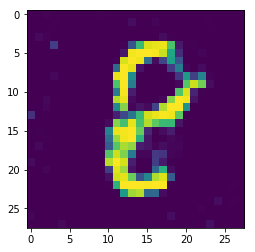

In [80]:
z = torch.randn(1, latent_size).to(device)
fake_images = G(z).view(28, 28).data.cpu().numpy()
plt.imshow(fake_images)

真实图片

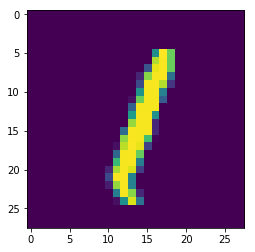

In [85]:
plt.imshow(images[0].view(28,28).data.cpu().numpy())

## DCGAN

[UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf)

In [109]:
import torchvision.utils as vutils

In [114]:
# !ls celeba/img_align_celeba/img_align_celeba_png

In [116]:
image_size=64
batch_size=128
dataroot="celeba/img_align_celeba"
num_workers = 2
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


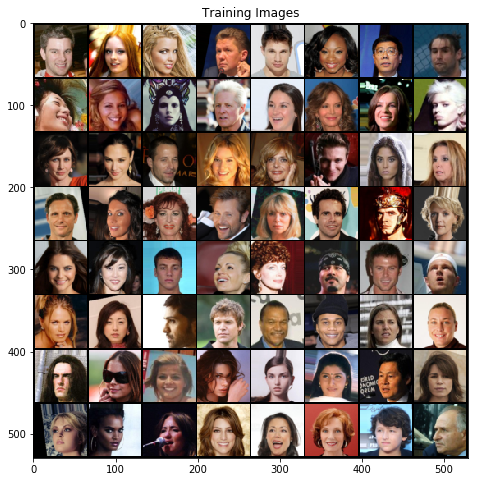

In [118]:
real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis=("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))


我们把模型的所有参数都初始化城mean=0, std=0.2

In [119]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![dcgan](images/dcgan_generator.png)

In [120]:
nz = 100 # latent vector的大小
ngf = 64 # generator feature map size
ndf = 64 # discriminator feature map size
nc = 3 # color channels

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [121]:
# Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator

In [122]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [123]:
# Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

# Create the Discriminator
netD = Discriminator().to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)



开始训练

In [124]:
lr = 0.0002
beta1 = 0.5

loss_fn = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
d_optimizer = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [130]:
num_epochs = 5
G_losses = []
D_losses = []
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        # 训练discriminator, maximize log(D(x)) + log(1-D(G(z)))
        
        # 首先训练真实图片
        netD.zero_grad()
        
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones(b_size).to(device)
        output = netD(real_images).view(-1)
        
        
        real_loss = loss_fn(output, label)
        real_loss.backward()
        D_x = output.mean().item()
        
        
        # 然后训练生成的假图片
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0)
        output = netD(fake_images.detach()).view(-1)
        fake_loss = loss_fn(output, label)
        fake_loss.backward()
        D_G_z1 = output.mean().item()
        loss_D = real_loss + fake_loss
        d_optimizer.step()
        
        # 训练Generator 
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images).view(-1)
        loss_G = loss_fn(output, label)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        g_optimizer.step()
        
        if i % 50 == 0:
            print("[{}/{}] [{}/{}] Loss_D: {:.4f} Loss_G {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}"
                 .format(epoch, num_epochs, i, len(dataloader), loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        
        

[0/5] [0/809] Loss_D: 0.2847 Loss_G 2.9254 D(x): 0.8399 D(G(z)): 0.0663/0.0858
[0/5] [50/809] Loss_D: 0.6210 Loss_G 3.0399 D(x): 0.7392 D(G(z)): 0.1899/0.0654
[0/5] [100/809] Loss_D: 0.9720 Loss_G 6.6228 D(x): 0.7940 D(G(z)): 0.4324/0.0048
[0/5] [150/809] Loss_D: 1.0644 Loss_G 2.8158 D(x): 0.4945 D(G(z)): 0.0263/0.1070
[0/5] [200/809] Loss_D: 0.3491 Loss_G 4.5362 D(x): 0.8924 D(G(z)): 0.1738/0.0186
[0/5] [250/809] Loss_D: 0.5326 Loss_G 5.8692 D(x): 0.9094 D(G(z)): 0.2905/0.0053
[0/5] [300/809] Loss_D: 0.5081 Loss_G 3.6961 D(x): 0.8115 D(G(z)): 0.1890/0.0410
[0/5] [350/809] Loss_D: 0.7767 Loss_G 4.1078 D(x): 0.8361 D(G(z)): 0.3486/0.0355
[0/5] [400/809] Loss_D: 0.4657 Loss_G 2.6921 D(x): 0.8289 D(G(z)): 0.1505/0.1046
[0/5] [450/809] Loss_D: 0.2888 Loss_G 4.6915 D(x): 0.8740 D(G(z)): 0.1022/0.0137
[0/5] [500/809] Loss_D: 0.5442 Loss_G 3.4045 D(x): 0.8264 D(G(z)): 0.2281/0.0541
[0/5] [550/809] Loss_D: 0.8233 Loss_G 7.4292 D(x): 0.9545 D(G(z)): 0.4624/0.0029
[0/5] [600/809] Loss_D: 0.4924 

In [132]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
# fake

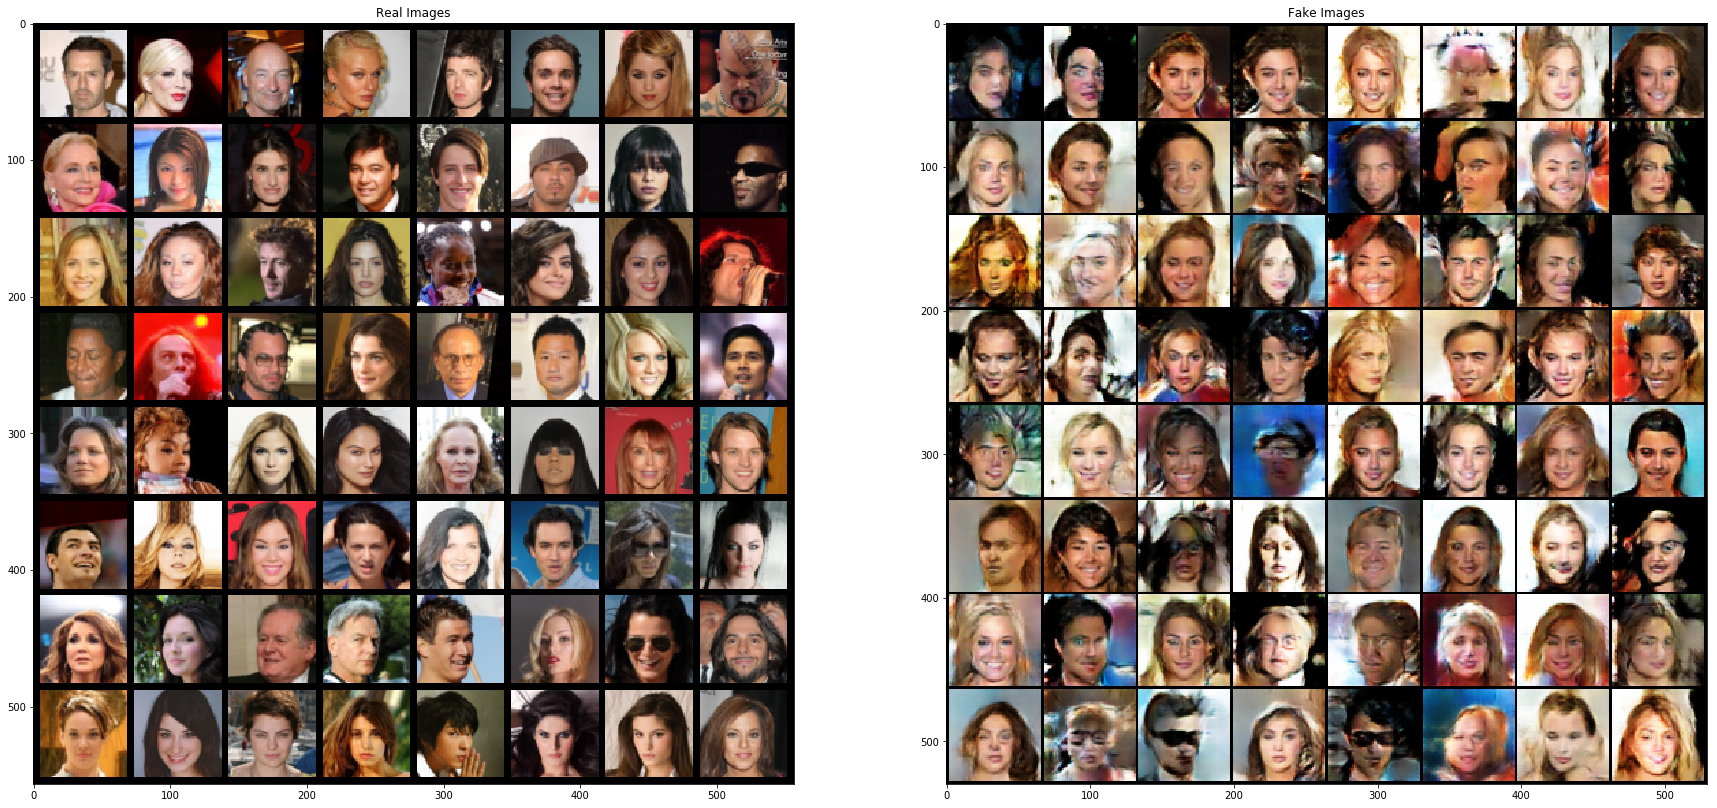

In [145]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis=("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis=("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()